In [1]:
# %load gibbs_example.py
"""
This is a small project where gibbs sampling (one of MCMC methods)
is used to solve a linear regression problems.

Description of the problem:
given a data set (x,y), use a linear regression model
y=a*x+b+epsilon, where a:gradient or slop, b: interception at
y axis, epsilon: fitting error ~ N(0,sigma^2).
Now we need to solve: a,b and sigma^2 for epsilon

The basic concept of gibbs sampling to
sample only one parameter at a time and keep other parameter unchanged in each sampling step:

At step t+1,
1. update b[t]-->b[t+1] first according to a derived density distribution function
g(b[t+1]|a[t],sigma[t],x)
2. update a[t]-->a[t+1] according to its derived density distribution function
h(a[t+1]|b[t+1],sigma[t],x)
3. update sigma[t]--> sigma[t+1] according to its derived density distribution function
j(sigma[t+1]|a[t+1],b[t+1],x)

refence: https://www.bilibili.com/video/BV17D4y1o7J2?p=5&spm_id_from=pageDriver&vd_source=a05a3848b5eba5baf58086fae3fbc91f
"""

import numpy as np
from scipy.stats import invgamma
import matplotlib.pyplot as plt
#from seaborn import plt
import pandas as pd

# update b, assuming b‘s prior is N(mu_b,sigma_b^2)
def gibbs_sampler_atb(a,sigma2,mu_b,sigma_b2,x,y):
    n=len(y)
    mean_= sigma2*mu_b + sigma_b2*np.sum(y-a*x)
    mean_/=sigma2+sigma_b2*n
    sigma_2=sigma2*sigma_b2
    sigma_2/=sigma2+sigma_b2*n
    return np.random.normal(mean_,np.sqrt(sigma_2))

#update a, assuming a's prior is N(mu_a,sigma_a^2)
def gibbs_sampler_ata(b,sigma2,mu_a,sigma_a2,x,y):
    mean_=sigma2*mu_a+sigma_a2*np.sum( (y-b) *x )
    mean_/=sigma2+sigma_a2*np.sum(x * x)
    sigma_2=sigma_a2*sigma2
    sigma_2/=sigma2+sigma_a2*np.sum(x**2)
    return np.random.normal(mean_,np.sqrt(sigma_2))

# update sigma^2, which is the variance of a normal distribution.
# For the moment, for an easier use of numpy, we sample (1/sigma^2) which follows gamma distribution.
# And take repo
# is assumed to be an inverse-gamma distribution:
# https://en.wikipedia.org/wiki/Inverse-gamma_distribution
def gibbs_sampler_atsigma2(alpha,beta,a,b,x,y):
    n = len(y)
    alpha_ = alpha + n / 2
    beta_ = beta + np.sum((y - b -a * x)**2) / 2
    return 1.0/np.random.gamma(alpha_, 1 / beta_)

#def gibbs_sampler_atsigma2(alpha,beta,a,b,x,y):
#    n=len(y)
#    alpha_=alpha+n*0.5
#    resid = y -b - a * x
#    beta_=beta+0.5*np.sum(resid * resid)
#   return invgamma.rvs(alpha_,1/beta_)

#initialize three parameters
def init_parameters(a0,b0,sigma2_0):
    init={"a_0":a0,
          "b_0":b0,
          "sigma2_0":sigma2_0}
    return init

#hyperparameters including：
#    a~N(mu_a,sigma_a2), b~N(mu_b,sigma_b2), sigma2~invgamma(alpha,beta)
#note here for a and b, sigma_a and sigma_b are set as hyperparameters instead of sigma_a^2
# and sigma_b^2
def hyperparameters(mu_a,sigma_a2,mu_b,sigma_b2,alpha,beta):
    hypers={"mu_a":mu_a,"sigma_a2":sigma_a2,
            "mu_b":mu_b,"sigma_b2":sigma_b2,
            "alpha":alpha,"beta":beta
    }
    return hypers

#generate synthetic data set
def synthetic_dataset_generator(a,b, sigma2,N):
    x=np.random.uniform(low=0,high=4,size=N)
    y=np.random.normal(a*x+b,np.sqrt(sigma2))
    return x,y

def gibbs_sampling(x,y,iters,init,hypers):
    a=init["a_0"]
    b=init["b_0"]
    sigma2=init["sigma2_0"]
    trace=np.zeros((iters,3))
    for i in range(iters):
        #update b
        b=gibbs_sampler_atb(a,sigma2,hypers["mu_a"],hypers["sigma_a2"],x,y)
        a=gibbs_sampler_ata(b,sigma2,hypers["mu_b"],hypers["sigma_b2"],x,y)
        sigma2= gibbs_sampler_atsigma2(hypers["alpha"],hypers["beta"],a,b,x,y)
        trace[i,:]=np.array((a,b,sigma2))
    trace=pd.DataFrame(trace)
    trace.columns=['a','b','sigma2']
    return trace

In [2]:
#generating sample data and set parameters values
init=init_parameters(0,0,0)
hypers=hyperparameters(0,1,0,1,2,1)
iters=1000

Mean values are:
 a         2.080750
b        -0.786882
sigma2    0.877852
dtype: float64
Standard derivations are:
 a         0.238426
b         0.530728
sigma2    0.438137
dtype: float64


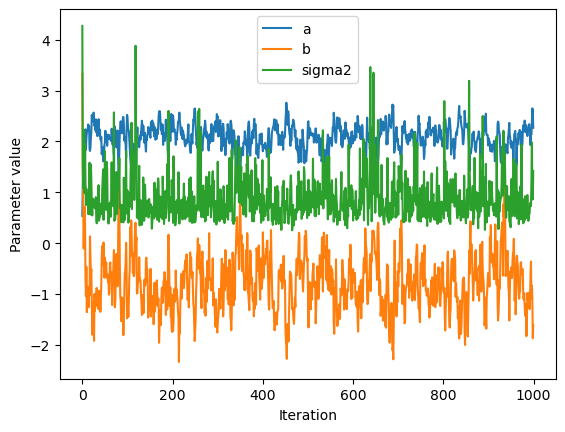

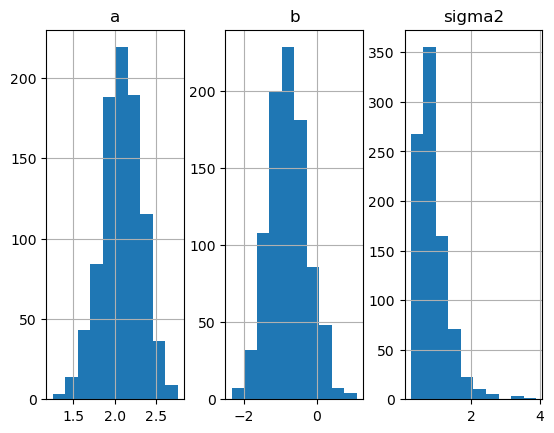

In [4]:
# when data number is 10
x,y=synthetic_dataset_generator(2,-1,1,10)

#plot results
trace=gibbs_sampling(x,y,iters,init,hypers)
traceplot=trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
trace_burnt=trace[100:]
trace_burnt.hist(bins=10,layout=(1,3))
print("Mean values are:\n",trace_burnt.mean())
print("Standard derivations are:\n",trace_burnt.std())

Mean values are:
 a         1.963044
b        -1.014197
sigma2    0.644929
dtype: float64
Standard derivations are:
 a         0.097963
b         0.221738
sigma2    0.126107
dtype: float64


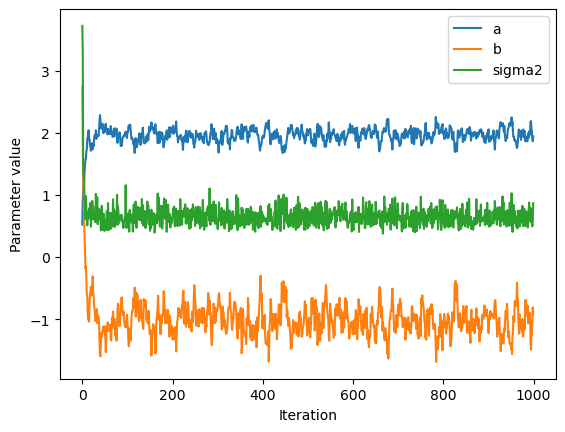

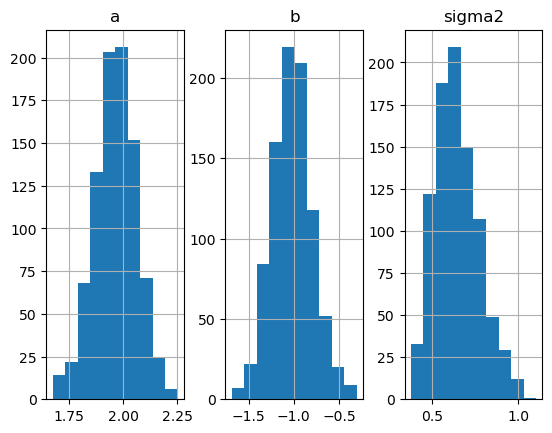

In [5]:
# when data number is 50
x,y=synthetic_dataset_generator(2,-1,1,50)

#plot results
trace=gibbs_sampling(x,y,iters,init,hypers)
traceplot=trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
trace_burnt=trace[100:]
trace_burnt.hist(bins=10,layout=(1,3))
print("Mean values are:\n",trace_burnt.mean())
print("Standard derivations are:\n",trace_burnt.std())

Mean values are:
 a         1.732803
b        -0.601128
sigma2    1.464985
dtype: float64
Standard derivations are:
 a         0.130483
b         0.336825
sigma2    0.306535
dtype: float64


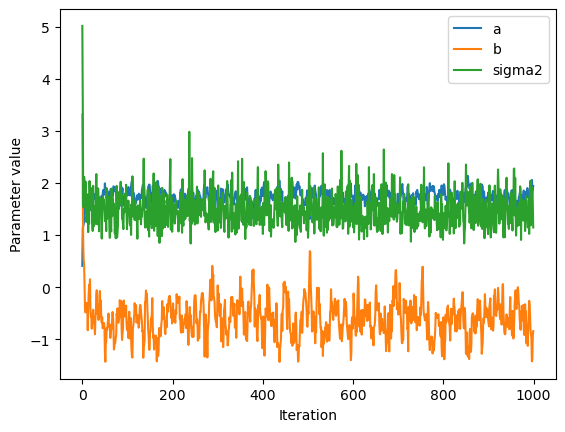

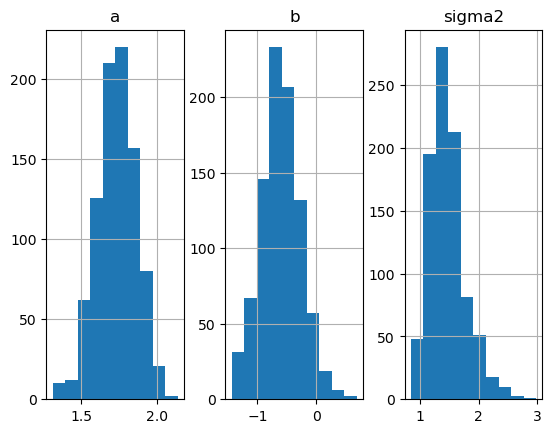

In [6]:
# when data number is 500
x,y=synthetic_dataset_generator(2,-1,1,50)

#plot results
trace=gibbs_sampling(x,y,iters,init,hypers)
traceplot=trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")
trace_burnt=trace[100:]
trace_burnt.hist(bins=10,layout=(1,3))
print("Mean values are:\n",trace_burnt.mean())
print("Standard derivations are:\n",trace_burnt.std())

From above, we see the more data we have, the faster the mcmc converges.